Dataset: https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

In [ ]:
classifiers = {
    'CNN': (0, 0, 0),
    'SVM': (0, 0, 0),
    'DTree': (0, 0, 0),
    'KNN': (0, 0, 0),
    'GNB': (0, 0, 0),
    'GBoost': (0, 0, 0)
}

In [ ]:
path_data = '/content/drive/MyDrive/NID_dataset/NID_dataset.csv'
path_model = '/content/drive/MyDrive/NID_dataset/nid_model.h5'

In [ ]:
# Load dataset
data = pd.read_csv(path_data)
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [ ]:
# Menghitung jumlah data berdasarkan nilai di kolom "class"
jumlah_data_class = data['class'].value_counts()

print("Jumlah data berdasarkan nilai 'class':")
print(jumlah_data_class)

Jumlah data berdasarkan nilai 'class':
normal     13449
anomaly    11743
Name: class, dtype: int64


In [ ]:
labels = ['No', 'Network Intrusi']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
# Menghitung jumlah data tiap kategori pada kolom "protocol_type"
protocol_type_counts = data['protocol_type'].value_counts()

# Membuat DataFrame dengan hasil perhitungan
result_df = pd.DataFrame({'Count': protocol_type_counts})

print("Data Protocol")
print(result_df)

Data Protocol
      Count
tcp   20526
udp    3011
icmp   1655


In [ ]:
# Menghitung jumlah data tiap kategori pada kolom "service"
service_counts = data['service'].value_counts()

# Membuat DataFrame dengan hasil perhitungan
result_df = pd.DataFrame({'Count': service_counts})

print("Data Service")
print(result_df)

Data Service
           Count
http        8003
private     4351
domain_u    1820
smtp        1449
ftp_data    1396
...          ...
urh_i          4
red_i          3
pm_dump        3
tim_i          2
http_8001      1

[66 rows x 1 columns]


In [ ]:
# Menghitung jumlah data tiap kategori pada kolom "flag"
flag_counts = data['flag'].value_counts()

# Membuat DataFrame dengan hasil perhitungan
result_df = pd.DataFrame({'Count': flag_counts})

print("Data Flag")
print(result_df)

Data Flag
        Count
SF      14973
S0       7009
REJ      2216
RSTR      497
RSTO      304
S1         88
SH         43
RSTOS0     21
S2         21
S3         15
OTH         5


In [ ]:
# Menghitung jumlah data tiap kategori pada kolom "class"
class_counts = data['class'].value_counts()

# Membuat DataFrame dengan hasil perhitungan
result_df = pd.DataFrame({'Count': class_counts})

print("Data Class")
print(result_df)

Data Class
         Count
normal   13449
anomaly  11743


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,25192.0,305.054104,2.686556e+03,0.0,0.00,0.00,0.00,42862.0
src_bytes,25192.0,24330.628215,2.410805e+06,0.0,0.00,44.00,279.00,381709090.0
dst_bytes,25192.0,3491.847174,8.883072e+04,0.0,0.00,0.00,530.25,5151385.0
land,25192.0,0.000079,8.909946e-03,0.0,0.00,0.00,0.00,1.0
wrong_fragment,25192.0,0.023738,2.602208e-01,0.0,0.00,0.00,0.00,3.0
urgent,25192.0,0.000040,6.300408e-03,0.0,0.00,0.00,0.00,1.0
hot,25192.0,0.198039,2.154202e+00,0.0,0.00,0.00,0.00,77.0
num_failed_logins,25192.0,0.001191,4.541818e-02,0.0,0.00,0.00,0.00,4.0
logged_in,25192.0,0.394768,4.888105e-01,0.0,0.00,0.00,1.00,1.0
num_compromised,25192.0,0.227850,1.041735e+01,0.0,0.00,0.00,0.00,884.0


In [ ]:
kolom_text = ['protocol_type', 'service', 'flag', 'class']
data[kolom_text] = data[kolom_text].apply(lambda x: pd.factorize(x)[0])

In [ ]:
data[['protocol_type', 'service', 'flag', 'class']]

,protocol_type,service,flag,class
0,0,0,0,0
1,1,1,0,0
2,0,2,1,1
3,0,3,0,0
4,0,3,0,0
...,...,...,...,...
25187,0,43,5,1
25188,0,0,0,1
25189,0,2,2,1
25190,0,54,1,1


In [ ]:
def normalisasi(df):
  df_norm = (df-df.min())/(df.max()-df.min())
  return df_norm

In [ ]:
kolom_skala = ['duration', 'src_bytes',	'dst_bytes', 'hot', 'num_compromised', 'num_root', 'num_file_creations', 'count','srv_count','dst_host_count','dst_host_srv_count']
data[kolom_skala] = normalisasi(data[kolom_skala])

In [ ]:
data[['duration', 'src_bytes',	'dst_bytes', 'hot', 'num_compromised', 'num_root', 'num_file_creations', 'count','srv_count','dst_host_count','dst_host_srv_count']]

,duration,src_bytes,dst_bytes,hot,num_compromised,num_root,num_file_creations,count,srv_count,dst_host_count,dst_host_srv_count
0,0.0,1.286320e-06,0.000000,0.0,0.0,0.0,0.0,0.001961,0.001961,0.588235,0.098039
1,0.0,3.824902e-07,0.000000,0.0,0.0,0.0,0.0,0.023529,0.000000,1.000000,0.003922
2,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.239216,0.009804,1.000000,0.101961
3,0.0,6.077927e-07,0.001583,0.0,0.0,0.0,0.0,0.007843,0.007843,0.117647,1.000000
4,0.0,5.213394e-07,0.000082,0.0,0.0,0.0,0.0,0.056863,0.060784,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
25187,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.194118,0.011765,1.000000,0.027451
25188,0.0,8.750119e-07,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003922,0.152941
25189,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.203922,0.011765,1.000000,0.050980
25190,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.250980,0.033333,1.000000,0.078431


In [ ]:
# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  float64
 1   protocol_type                25192 non-null  int64  
 2   service                      25192 non-null  int64  
 3   flag                         25192 non-null  int64  
 4   src_bytes                    25192 non-null  float64
 5   dst_bytes                    25192 non-null  float64
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  float64
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  float64
 13  root_shell      

In [ ]:
num_output = data['class'].unique().size
num_output

2

In [ ]:
X = data.iloc[:, :-1].values  # Features :column selain class
y = data.iloc[:, -1].values   # Target : class

In [ ]:
# Split dataset
X_trains, X_tests, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [ ]:
# menghitung jumlah data normal dan anomali pada data training
jumlah_normal_train = sum(y_train == 0)
jumlah_anomali_train = sum(y_train == 1)

print("Jumlah data dengan label 'normal' pada data training:", jumlah_normal_train)
print("Jumlah data dengan label 'anomali' pada data training:", jumlah_anomali_train)

# menghitung jumlah data normal dan anomali pada data testing
jumlah_normal_test = sum(y_test == 0)
jumlah_anomali_test = sum(y_test == 1)

print("Jumlah data dengan label 'normal' pada data testing:", jumlah_normal_test)
print("Jumlah data dengan label 'anomali' pada data testing:", jumlah_anomali_test)

Jumlah data dengan label 'normal' pada data training: 10776
Jumlah data dengan label 'anomali' pada data training: 9377
Jumlah data dengan label 'normal' pada data testing: 2673
Jumlah data dengan label 'anomali' pada data testing: 2366


# Convolutional Neural Network

In [ ]:
# Zero padding
padding_value = 100  # Choose a value suitable for your dataset
X_train = np.pad(X_trains, ((0, 0), (0, padding_value - X_trains.shape[1])), mode='constant')
X_test = np.pad(X_tests, ((0, 0), (0, padding_value - X_tests.shape[1])), mode='constant')

In [ ]:
# Reshape input data for CNN
X_train = X_train.reshape(X_train.shape[0], padding_value, 1)
X_test = X_test.reshape(X_test.shape[0], padding_value, 1)

In [ ]:
# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# Define the ModelCheckpoint callback
val_checkpoint = ModelCheckpoint(path_model, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1)

In [ ]:
# Build CNN 1D model
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(padding_value, 1)),
    MaxPooling1D(),
    Dropout(0.3),
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(),
    Dropout(0.3),
    Conv1D(512, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

if(num_output == 2):
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           98560     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 256)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[val_checkpoint])

Epoch 1/200
315/315 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8900
Epoch 1: val_accuracy improved from -inf to 0.95495, saving model to /content/drive/MyDrive/NID_dataset/nid_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


315/315 [==============================] - 64s 195ms/step - loss: 0.2535 - accuracy: 0.8900 - val_loss: 0.1326 - val_accuracy: 0.9550
Epoch 2/200
315/315 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9527
Epoch 2: val_accuracy improved from 0.95495 to 0.96150, saving model to /content/drive/MyDrive/NID_dataset/nid_model.h5
315/315 [==============================] - 62s 198ms/step - loss: 0.1370 - accuracy: 0.9527 - val_loss: 0.1104 - val_accuracy: 0.9615
Epoch 3/200
315/315 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9600
Epoch 3: val_accuracy improved from 0.96150 to 0.96269, saving model to /content/drive/MyDrive/NID_dataset/nid_model.h5
315/315 [==============================] - 61s 194ms/step - loss: 0.1180 - accuracy: 0.9600 - val_loss: 0.1011 - val_accuracy: 0.9627
Epoch 4/200
315/315 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.9623
Epoch 4: val_accuracy improved from 0.96269 to 0.96765, saving mode

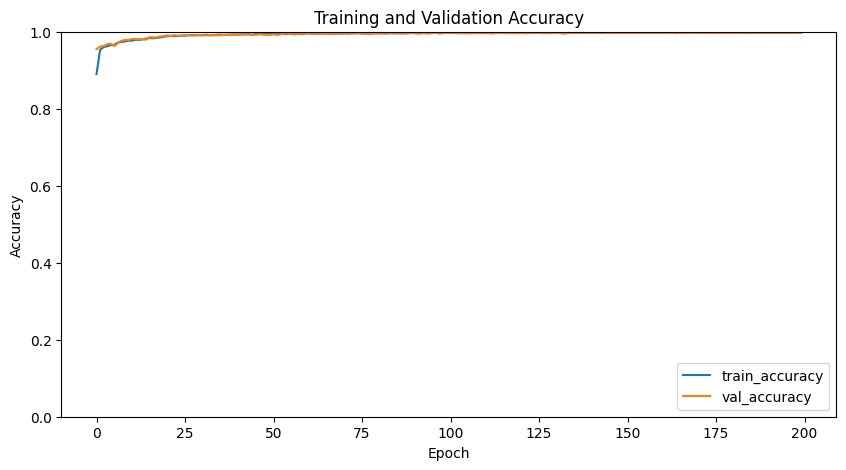

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print("Train_Accuracy", accuracy)
print("Val_Accuracy", val_accuracy)

Train_Accuracy [0.890041172504425, 0.9527117609977722, 0.9600059390068054, 0.962288498878479, 0.9651168584823608, 0.9658611416816711, 0.9718652367591858, 0.9731057286262512, 0.9749416708946228, 0.9765295386314392, 0.9769265055656433, 0.9790105819702148, 0.9788616895675659, 0.9800029993057251, 0.9821366667747498, 0.9834764003753662, 0.98312908411026, 0.9838237762451172, 0.9851138591766357, 0.9868506193161011, 0.9886369109153748, 0.9885376691818237, 0.9887361526489258, 0.9884880781173706, 0.9898278117179871, 0.9896789789199829, 0.9908698201179504, 0.9907705783843994, 0.9915645122528076, 0.9907209873199463, 0.9911179542541504, 0.9922096133232117, 0.9907209873199463, 0.9915149211883545, 0.9917629957199097, 0.9924576878547668, 0.9918622374534607, 0.9922096133232117, 0.9925073385238647, 0.9930035471916199, 0.9927058219909668, 0.993053138256073, 0.9933508634567261, 0.993251621723175, 0.9923584461212158, 0.9939463138580322, 0.9939463138580322, 0.9941447973251343, 0.993598997592926, 0.994541764

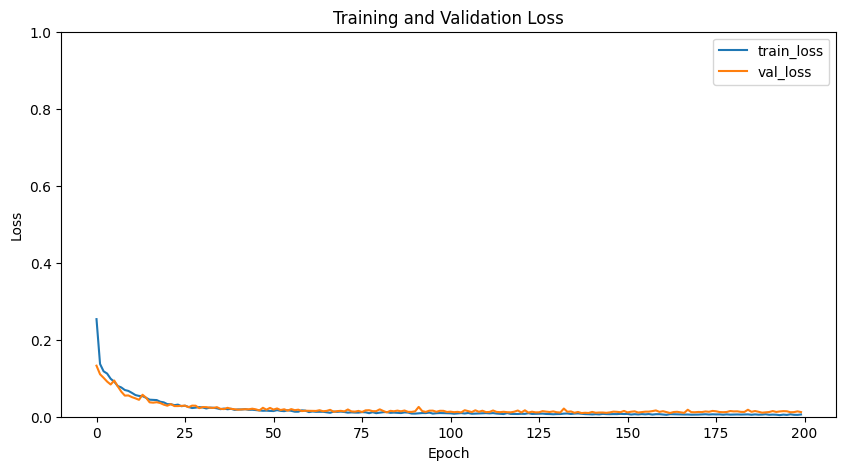

In [ ]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Train_Loss", loss)
print("Val_Loss", val_loss)

Train_Loss [0.2534961700439453, 0.1370334029197693, 0.11800341308116913, 0.11207299679517746, 0.09856273978948593, 0.09106528013944626, 0.07980244606733322, 0.07605009526014328, 0.06936309486627579, 0.06701874732971191, 0.06194521114230156, 0.056263428181409836, 0.05400322750210762, 0.0535142682492733, 0.04908163473010063, 0.04422052204608917, 0.04361730441451073, 0.04324367269873619, 0.038951143622398376, 0.03728155791759491, 0.03269476816058159, 0.032594047486782074, 0.029983004555106163, 0.03141389042139053, 0.027337688952684402, 0.028711115941405296, 0.025272473692893982, 0.022555021569132805, 0.02359846979379654, 0.025001980364322662, 0.024077177047729492, 0.021432233974337578, 0.02353372983634472, 0.023304533213377, 0.02188081294298172, 0.019607210531830788, 0.021170243620872498, 0.019359292462468147, 0.020631983876228333, 0.017743760719895363, 0.01895446516573429, 0.01877775974571705, 0.01964055374264717, 0.017924202606081963, 0.01817411184310913, 0.017244715243577957, 0.0165693

In [ ]:
mymodel = load_model(path_model)

In [ ]:
# Evaluate the model
y_pred = mymodel.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

158/158 [==============================] - 3s 19ms/step


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

report = classification_report(y_test, y_pred_classes, output_dict=True)['weighted avg']
classifiers['CNN'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2670    3]
 [   7 2359]]

Classification Report:
                 precision    recall  f1-score   support

             No       1.00      1.00      1.00      2673
Network Intrusi       1.00      1.00      1.00      2366

       accuracy                           1.00      5039
      macro avg       1.00      1.00      1.00      5039
   weighted avg       1.00      1.00      1.00      5039



# SVM with RBF Kernel

In [ ]:
# SVM
clf_SVM = SVC(kernel='rbf', C=2)
clf_SVM.fit(X_trains, y_train)
y_pred = clf_SVM.predict(X_tests)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
classifiers['SVM'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2623   50]
 [ 138 2228]]

Classification Report:
                 precision    recall  f1-score   support

             No       0.95      0.98      0.97      2673
Network Intrusi       0.98      0.94      0.96      2366

       accuracy                           0.96      5039
      macro avg       0.96      0.96      0.96      5039
   weighted avg       0.96      0.96      0.96      5039



# Decision Tree with 'Entropy' criterion

In [ ]:
# Decision Tree
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf_DT.fit(X_trains, y_train)
y_pred = clf_DT.predict(X_tests)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
classifiers['DTree'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2595   78]
 [  56 2310]]

Classification Report:
                 precision    recall  f1-score   support

             No       0.98      0.97      0.97      2673
Network Intrusi       0.97      0.98      0.97      2366

       accuracy                           0.97      5039
      macro avg       0.97      0.97      0.97      5039
   weighted avg       0.97      0.97      0.97      5039



# K-Nearest Neighbors (KNN)

In [ ]:
clf_KNN = KNeighborsClassifier(n_neighbors=7)
clf_KNN.fit(X_trains, y_train)
y_pred = clf_KNN.predict(X_tests)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
classifiers['KNN'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2646   27]
 [  34 2332]]

Classification Report:
                 precision    recall  f1-score   support

             No       0.99      0.99      0.99      2673
Network Intrusi       0.99      0.99      0.99      2366

       accuracy                           0.99      5039
      macro avg       0.99      0.99      0.99      5039
   weighted avg       0.99      0.99      0.99      5039



# Gaussian Naive Bayes

In [ ]:
# Gaussian Naive bayes
clf_NB = GaussianNB()
clf_NB.fit(X_trains, y_train)
y_pred = clf_NB.predict(X_tests)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
classifiers['GNB'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2326  347]
 [ 197 2169]]

Classification Report:
                 precision    recall  f1-score   support

             No       0.92      0.87      0.90      2673
Network Intrusi       0.86      0.92      0.89      2366

       accuracy                           0.89      5039
      macro avg       0.89      0.89      0.89      5039
   weighted avg       0.89      0.89      0.89      5039



# Gradient Boost

In [ ]:
clf_GR = GradientBoostingClassifier()
clf_GR.fit(X_trains, y_train)
y_pred = clf_GR.predict(X_tests)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

report = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
classifiers['GBoost'] = (report['precision'], report['recall'], report['f1-score'])

Confusion Matrix:
[[2653   20]
 [  15 2351]]

Classification Report:
                 precision    recall  f1-score   support

             No       0.99      0.99      0.99      2673
Network Intrusi       0.99      0.99      0.99      2366

       accuracy                           0.99      5039
      macro avg       0.99      0.99      0.99      5039
   weighted avg       0.99      0.99      0.99      5039



# Perbandingan Model

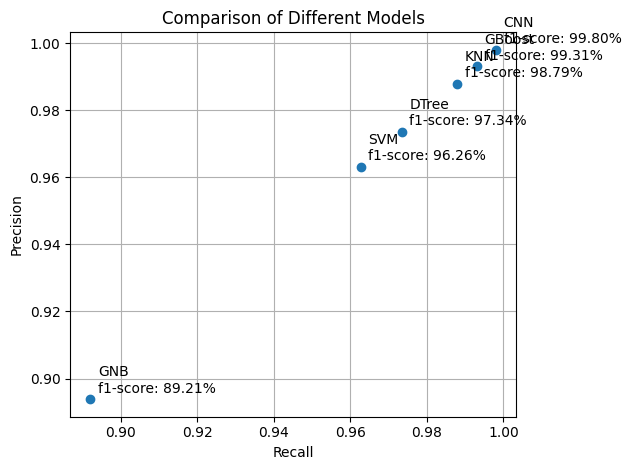

In [ ]:
precision   = [classifiers[model][0] for model in classifiers.keys()]
recall      = [classifiers[model][1] for model in classifiers.keys()]
f1_score    = [classifiers[model][2] for model in classifiers.keys()]
annot        = [f'{clf}\nf1-score: {classifiers[clf][2]:.2%}' for clf in classifiers]

plt.title('Comparison of Different Models')
plt.scatter(recall, precision)

# Add label to data points
margin = 0.002
for (x, y, t) in zip(recall, precision, annot):
    plt.text(x + margin, y + margin, t)

plt.xlabel('Recall'), plt.ylabel('Precision')
plt.grid()

plt.tight_layout()
plt.savefig('ModelComparison.jpg', dpi=300)
plt.show()